In [1]:
%cd C:\Users\kandu\VITON-HD

C:\Users\kandu\VITON-HD


C:\Users\kandu\anaconda3\envs\myenvpytorch\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
print(os.getcwd())


C:\Users\kandu\VITON-HD


In [2]:
import torch
import torchvision
import cv2
import torchgeometry


In [3]:
import torch
torch.cuda.empty_cache()


In [17]:
!python test.py --name experiment_name --dataset_dir C:\Users\kandu\Downloads\zalando --dataset_mode unaligned --checkpoint_dir checkpoints --batch_size 1 --workers 0


Namespace(name='experiment_name', batch_size=1, workers=0, load_height=1024, load_width=768, shuffle=False, dataset_dir='C:\\Users\\kandu\\Downloads\\zalando', dataset_mode='unaligned', dataset_list='test_pairs.txt', checkpoint_dir='checkpoints', save_dir='./results/', display_freq=1, seg_checkpoint='seg_final.pth', gmm_checkpoint='gmm_final.pth', alias_checkpoint='alias_final.pth', semantic_nc=13, init_type='xavier', init_variance=0.02, grid_size=5, norm_G='spectralaliasinstance', ngf=64, num_upsampling_layers='most')
Network [SegGenerator] was created. Total number of parameters: 34.5 million. To see the architecture, do print(network).
Network [ALIASGenerator] was created. Total number of parameters: 100.5 million. To see the architecture, do print(network).
step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8
step: 9
step: 10
step: 11
step: 12
step: 13
step: 14
step: 15
step: 16
step: 17
step: 18
step: 19
step: 20
step: 21
step: 22
step: 23
step: 24
step: 25
step: 26
ste

C:\Users\kandu\VITON-HD\utils.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))
C:\Users\kandu\anaconda3\envs\myenvpyto

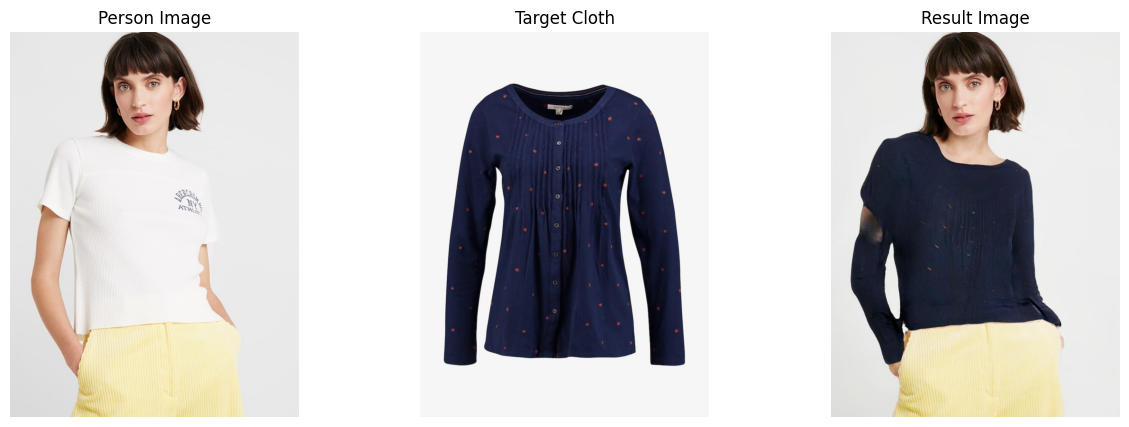

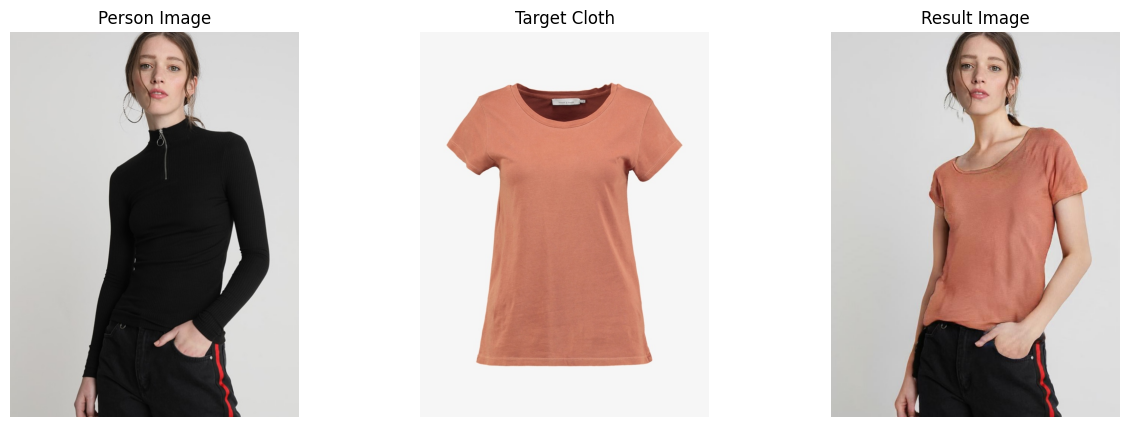

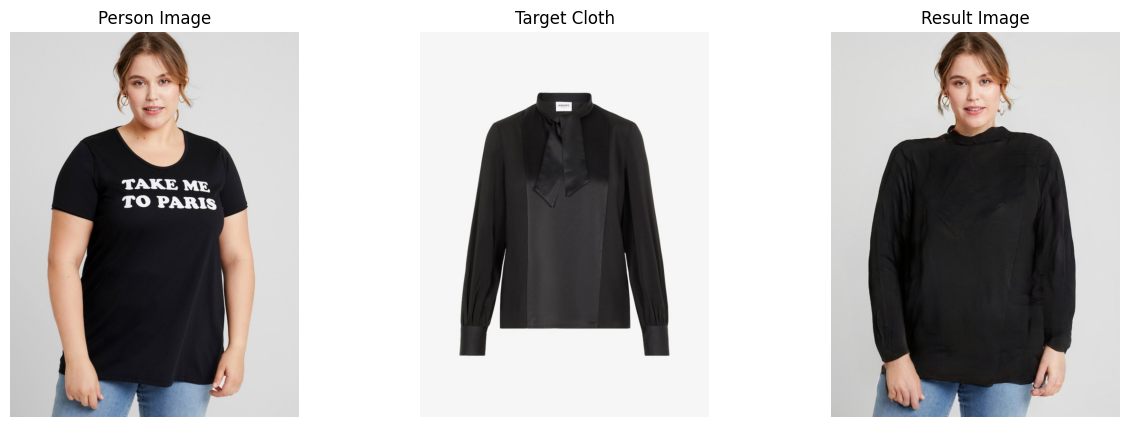

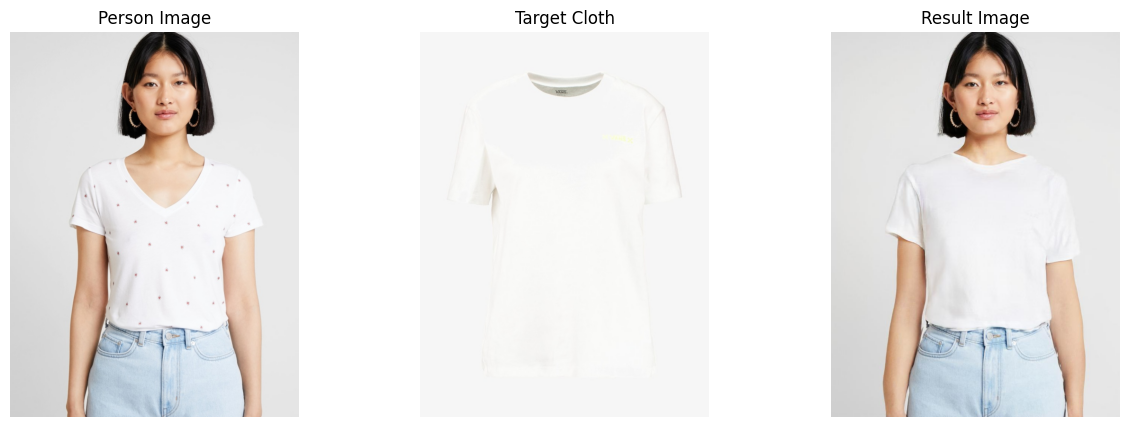

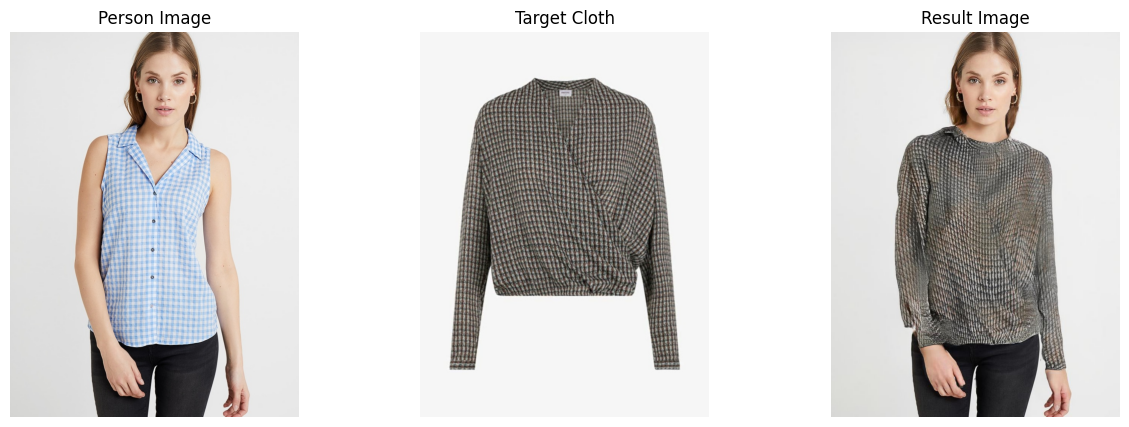

In [23]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Define paths
dataset_dir = 'C:\\Users\\kandu\\Downloads\\zalando'
person_images_dir = os.path.join(dataset_dir, 'unaligned', 'image')
cloth_images_dir = os.path.join(dataset_dir, 'unaligned', 'cloth')
result_images_dir = 'C:\\Users\\kandu\\VITON-HD\\results\\experiment_name'

# List all result images in the experiment_name folder
result_images = os.listdir(result_images_dir)

# Randomly sample 5 result images
sample_result_images = random.sample(result_images, 5)

# Visualize each sampled result image with its corresponding person and cloth images
for result_image_name in sample_result_images:
    # Parse personID and clothID from result image name
    person_id = result_image_name.split('_')[0] + '_00.jpg'   # Person ID with _00 suffix
    cloth_id = result_image_name.split('_')[1] + '_00.jpg'    # Cloth ID with _00 suffix
    
    # Define paths to the person and cloth images
    person_image_path = os.path.join(person_images_dir, person_id)
    cloth_image_path = os.path.join(cloth_images_dir, cloth_id)
    result_image_path = os.path.join(result_images_dir, result_image_name)

    # Check if all images exist
    if not all(os.path.exists(path) for path in [person_image_path, cloth_image_path, result_image_path]):
        print(f"Missing file for result image: {result_image_name}")
        continue

    # Load images
    person_image = Image.open(person_image_path)
    cloth_image = Image.open(cloth_image_path)
    result_image = Image.open(result_image_path)

    # Display images side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(person_image)
    axes[0].set_title('Person Image')
    axes[0].axis('off')

    axes[1].imshow(cloth_image)
    axes[1].set_title('Target Cloth')
    axes[1].axis('off')

    axes[2].imshow(result_image)
    axes[2].set_title('Result Image')
    axes[2].axis('off')

    plt.show()


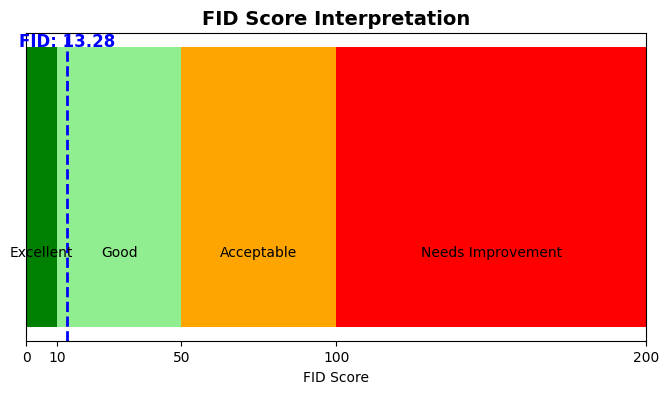

In [5]:
import torch
import numpy as np
from PIL import Image
from torchvision import models, transforms
from scipy.linalg import sqrtm
from torch.nn.functional import adaptive_avg_pool2d
import os
import matplotlib.pyplot as plt

# Paths
generated_images_dir = 'C:\\Users\\kandu\\VITON-HD\\results\\experiment_name'
real_images_dir = 'C:\\Users\\kandu\\Downloads\\zalando\\unaligned\\image'  # Real person images as a reference

# Load Inception v3 model for feature extraction
inception_model = models.inception_v3(weights="Inception_V3_Weights.DEFAULT", transform_input=False)
inception_model.fc = torch.nn.Identity()  # Remove final classification layer
inception_model.eval().cuda()

# Preprocessing
preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def calculate_activation_statistics(images, model):
    act = []
    for img_path in images:
        img = Image.open(img_path).convert('RGB')
        img = preprocess(img).unsqueeze(0).cuda()
        with torch.no_grad():
            pred = model(img)
            if pred.dim() == 4:  # Check if output has 4 dimensions
                pred = adaptive_avg_pool2d(pred, (1, 1)).squeeze().cpu().numpy()
            else:
                pred = pred.squeeze().cpu().numpy()
        act.append(pred)
    act = np.array(act)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

# Load images
generated_images = [os.path.join(generated_images_dir, f) for f in os.listdir(generated_images_dir)]
real_images = [os.path.join(real_images_dir, f) for f in os.listdir(real_images_dir)]

# Calculate FID
mu_gen, sigma_gen = calculate_activation_statistics(generated_images, inception_model)
mu_real, sigma_real = calculate_activation_statistics(real_images, inception_model)

# Compute FID and take real part only
fid_score = np.sum((mu_gen - mu_real)**2) + np.trace(sigma_gen + sigma_real - 2 * sqrtm(sigma_gen @ sigma_real).real)

# Visualization Code for FID Interpretation
# Define FID ranges and labels
ranges = [0, 10, 50, 100, 200]  # Adjust ranges based on typical FID score interpretation
labels = ["Excellent", "Good", "Acceptable", "Needs Improvement"]
colors = ["green", "lightgreen", "orange", "red"]

# Create gauge-like plot
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

# Plot colored ranges
for i in range(len(ranges) - 1):
    ax.barh(0, ranges[i + 1] - ranges[i], left=ranges[i], color=colors[i], edgecolor="none", height=0.4)

# Add vertical line for the FID score
ax.axvline(fid_score, color="blue", linestyle="--", linewidth=2)
ax.text(fid_score, 0.2, f"FID: {fid_score:.2f}", ha="center", color="blue", fontsize=12, fontweight="bold")

# Label sections
for i in range(len(labels)):
    ax.text((ranges[i] + ranges[i + 1]) / 2, -0.1, labels[i], ha="center", color="black", fontsize=10)

# Customize plot
ax.set_xlim(0, ranges[-1])
ax.set_yticks([])
ax.set_xticks(ranges)
ax.set_title("FID Score Interpretation", fontsize=14, fontweight="bold")
ax.set_xlabel("FID Score")

plt.show()


In [9]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import os
from scipy.stats import entropy

# Directory for generated images
generated_images_dir = 'C:\\Users\\kandu\\VITON-HD\\results\\experiment_name'

# Load Inception model
inception_model = models.inception_v3(weights="Inception_V3_Weights.DEFAULT")
inception_model.fc = torch.nn.Identity()  # Remove classification layer
inception_model.eval().cuda()

# Preprocessing for Inception model
preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to calculate Inception Score
def calculate_inception_score(images, model, splits=10):
    preds = []

    for img_path in images:
        img = Image.open(img_path).convert('RGB')
        img = preprocess(img).unsqueeze(0).cuda()
        
        with torch.no_grad():
            pred = model(img)
            pred = F.softmax(pred, dim=1)
            preds.append(pred.cpu().numpy())

    preds = np.concatenate(preds, axis=0)

    # Split predictions and compute IS
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds) // splits): (k + 1) * (len(preds) // splits), :]
        py = np.mean(part, axis=0)
        scores = [entropy(pyx, py) for pyx in part]
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

# Load generated images
generated_images = [os.path.join(generated_images_dir, f) for f in os.listdir(generated_images_dir) if f.endswith('.jpg')]

# Calculate and print Inception Score
mean_is, std_is = calculate_inception_score(generated_images, inception_model)
print(f"Inception Score: {mean_is:.2f} ± {std_is:.2f}")


Inception Score: 1.04 ± 0.00


In [11]:

from torchvision import models, transforms

# Directory for generated images
generated_images_dir = 'C:\\Users\\kandu\\VITON-HD\\results\\experiment_name'

# Load the pretrained Inception model for feature extraction
inception_model = models.inception_v3(weights="Inception_V3_Weights.DEFAULT", transform_input=False)
inception_model.fc = torch.nn.Identity()  # Remove classification layer for feature extraction
inception_model.eval().cuda()

# Preprocessing for Inception model
preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to calculate PPL
def calculate_ppl(images, model, epsilon=1e-4, batch_size=4):
    distances = []
    for i in range(0, len(images) - 1, batch_size):
        batch = images[i:i + batch_size]
        
        img1 = Image.open(batch[0]).convert('RGB')
        img2 = Image.open(batch[1]).convert('RGB')
        
        img1 = preprocess(img1).unsqueeze(0).cuda()
        img2 = preprocess(img2).unsqueeze(0).cuda()
        
        with torch.no_grad():
            feat1 = model(img1)
            feat2 = model(img2)
        
        # Calculate L2 distance in feature space
        l2_dist = F.mse_loss(feat1, feat2)
        distances.append(l2_dist.item())

    return np.mean(distances), np.std(distances)

# Load images in pairs
generated_images = [os.path.join(generated_images_dir, f) for f in os.listdir(generated_images_dir) if f.endswith('.jpg')]
pairs = [(generated_images[i], generated_images[i + 1]) for i in range(0, len(generated_images) - 1, 2)]

# Calculate Perceptual Path Length
mean_ppl, std_ppl = calculate_ppl(generated_images, inception_model)
print(f"Perceptual Path Length: {mean_ppl:.4f} ± {std_ppl:.4f}")


Perceptual Path Length: 0.0990 ± 0.0279


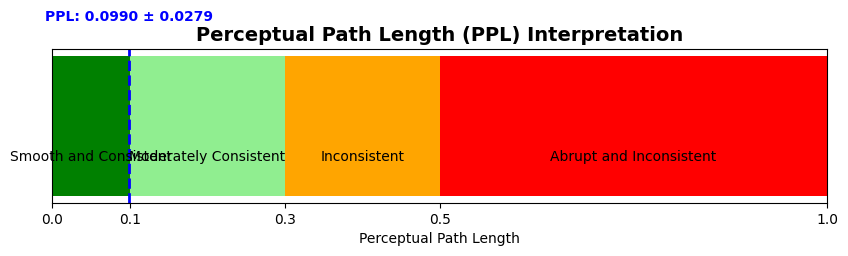

In [12]:

# Define example thresholds for interpretation
thresholds = [0, 0.1, 0.3, 0.5, 1.0]  # Adjust as needed based on typical PPL scores
labels = ["Smooth and Consistent", "Moderately Consistent", "Inconsistent", "Abrupt and Inconsistent"]
colors = ["green", "lightgreen", "orange", "red"]

# Create gauge plot
fig, ax = plt.subplots(figsize=(10, 2), dpi=100)

# Plot colored ranges
for i in range(len(thresholds) - 1):
    ax.barh(0, thresholds[i + 1] - thresholds[i], left=thresholds[i], color=colors[i], height=0.4, edgecolor="none")

# Plot the PPL score as a vertical line
ax.axvline(mean_ppl, color="blue", linestyle="--", linewidth=2)
ax.text(mean_ppl, 0.3, f"PPL: {mean_ppl:.4f} ± {std_ppl:.4f}", ha="center", color="blue", fontweight="bold")

# Label each range
for i in range(len(labels)):
    ax.text((thresholds[i] + thresholds[i + 1]) / 2, -0.1, labels[i], ha="center", color="black", fontsize=10)

# Customize plot
ax.set_xlim(0, thresholds[-1])
ax.set_yticks([])
ax.set_xticks(thresholds)
ax.set_title("Perceptual Path Length (PPL) Interpretation", fontsize=14, fontweight="bold")
ax.set_xlabel("Perceptual Path Length")

plt.show()


In [5]:
!python test.py --name demo_test --dataset_dir C:\Users\kandu\VITON-HD\datasets --dataset_mode test --checkpoint_dir checkpoints --batch_size 1 --workers 0



Namespace(name='demo_test', batch_size=1, workers=0, load_height=1024, load_width=768, shuffle=False, dataset_dir='C:\\Users\\kandu\\VITON-HD\\datasets', dataset_mode='test', dataset_list='test_pairs.txt', checkpoint_dir='checkpoints', save_dir='./results/', display_freq=1, seg_checkpoint='seg_final.pth', gmm_checkpoint='gmm_final.pth', alias_checkpoint='alias_final.pth', semantic_nc=13, init_type='xavier', init_variance=0.02, grid_size=5, norm_G='spectralaliasinstance', ngf=64, num_upsampling_layers='most')
Network [SegGenerator] was created. Total number of parameters: 34.5 million. To see the architecture, do print(network).
Network [ALIASGenerator] was created. Total number of parameters: 100.5 million. To see the architecture, do print(network).
step: 1
step: 2
step: 3
step: 4
step: 5
step: 6


C:\Users\kandu\VITON-HD\utils.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))
C:\Users\kandu\anaconda3\envs\myenvpyto